In [56]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
    dx
)
from scipy.interpolate import CubicSpline
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix, Expression, assemble_scalar
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


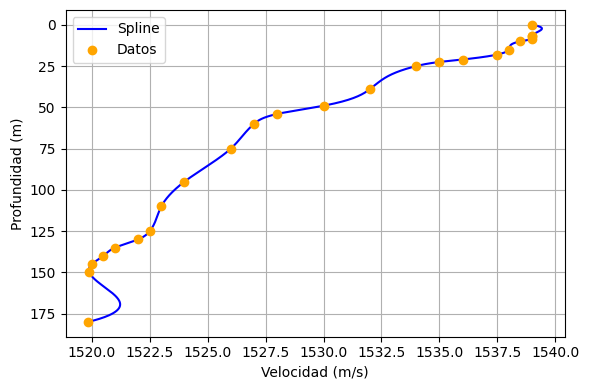

In [57]:
# Define element size for the mesh refinement
h=10.0  # element size


# Domain configuration
Lx = 800. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
rho_media_2 = 1. # kg/m^3

# PML configuration
pml_thickness = Lx/2

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

# Perfil Oman real
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Datos originales
data_sound_speed = [
    1519.85, 1519.9, 1520, 1520.5, 1521.0, 1522, 1522.5, 1523, 1524, 1526,
    1527, 1528, 1530, 1532, 1534, 1535, 1536, 1537.5, 1538, 1538.5,
    1539, 1539, 1539, 1539,
]

data_depth = [-180, -150, -145, -140, -135, -130, -125, -110, -95, -75, -60,
              -54, -49, -39, -25, -22.5, -21, -18, -15, -10, -8.5, -7, -6.5, -0]

# 1) Convertir a profundidad positiva
depth = np.array([-d for d in data_depth])
sound_speed = np.array(data_sound_speed)

# 2) ORDENAR CRECIENTE
order = np.argsort(depth)
depth = depth[order]
sound_speed = sound_speed[order]

# 3) Crear spline correcto
spline = CubicSpline(depth, sound_speed, extrapolate=True)

# 4) Para Fenics: función vectorizada
def vel_function(x):
    return spline(x[0])

# --- Plot ---
depth_fine = np.linspace(depth.min(), depth.max(), 500)
sound_speed_fine = spline(depth_fine)

plt.figure(figsize=(6,4))
plt.plot(sound_speed_fine, depth_fine, label="Spline", color="blue")
plt.plot(sound_speed, depth, "o", label="Datos", color="orange")

plt.gca().invert_yaxis()
plt.xlabel("Velocidad (m/s)")
plt.ylabel("Profundidad (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [58]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(target)  
    solver.solve()
    n_eigs_converged_singular = solver.getConverged()

    return solver, mesh, Q, V, dof

In [59]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof, normalize_at):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    # --- normalización opcional ---
    if normalize_at is not None:
        p_norm = p_h.eval(normalize_at, 1)
        v_norm = v_h.eval(normalize_at, 1)
        if abs(p_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de p.")
        if abs(v_norm) == 0:
            raise RuntimeError("Non se pode normalizar: valor 0 no punto dado de v.")

        p_h.x.array[:] /= p_norm
        v_h.x.array[:] /= v_norm
    return p_h, v_h

In [60]:
def get_function_plot_data(u):
    """
    Devolve (x_sorted, values_sorted) listos para plt.plot.

    Funciona en mallas 1D en dolfinx 0.9.
    Usa coordenadas dos DOFs do espazo de u.
    """

    V = u.function_space
    mesh = V.mesh

    # Coordenadas dos DOFs
    X = V.tabulate_dof_coordinates().copy()

    # COLAPSAR dimensións sobrantes: quedamos coa coordenada x
    if X.shape[1] > 1:
        X = X[:, 0]

    # Obter valores da función
    try:
        vals = u.x.array.copy()
    except AttributeError:
        vals = u.vector.getArray().copy()

    # Ordenar por coordenada x
    idx = np.argsort(X)
    return X[idx], vals[idx]


In [61]:
def get_n_approx_eigenpair(solver, Q, V, dof, n,):
    """
    Devuelve el autovalor y autovector número n

    Returns
    -------
    p_h:    Function
    v_h: Function
    """
    # Vector temporal para extraer Eigenpairs
    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    vrA, vi_0 = solver.getOperators()[0].getVecs()
    eig=solver.getEigenvalue(n) * 1j 
    solver.getEigenpair(n, vrA)
    [p_h, v_h]= assign_eigenvector_to_functions(vrA = vrA, p_h = p_h, v_h = v_h, dof = dof, normalize_at = [Lx, 0, 0])

    return eig, p_h, v_h


In [62]:
eigs = []
p = []
v = []
# PML configuration
pml_thickness = Lx/2
# sigma_0 = 1 #0.484375

# Solver configuration
requested_eigenvalues_number = 50 # Number of eigenvalues to compute


degree=[3,2]  # Polynomial degree for pressure and velocity
target=1j
mesh = create_interval(
        MPI.COMM_WORLD,
        int((Lx + pml_thickness) / h),
        [0, Lx + pml_thickness]
    )
sigma_singular_ufl=lambda x: conditional(x[0] > Lx, 1/(Lx+pml_thickness-x[0]), 0.0)
solver_singular, mesh, Q_, V_, dof_ = get_configured_problem(mesh, degree, sigma_singular_ufl)
for n in range(solver_singular.getConverged()):
    eig_singular, p_singular, v_singular = get_n_approx_eigenpair(solver_singular, Q_, V_, dof_, n)
    eigs.append(eig_singular)
    p.append(p_singular)
    v.append(v_singular) 
    

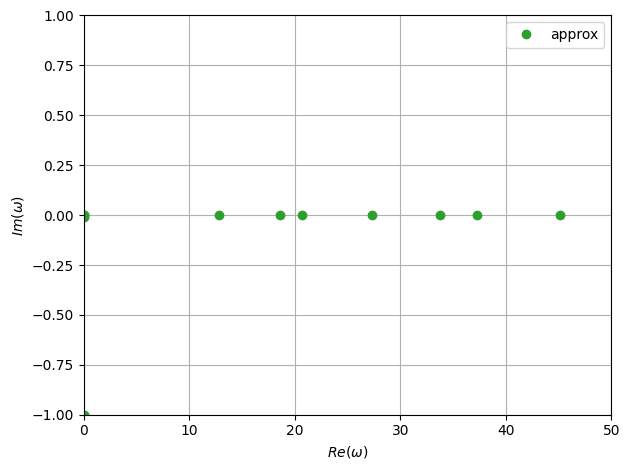

In [66]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig

# N=2, eig 0
# plt.plot(sigma_sweep_piecewise, rel_error_eig_0_piecewise_n_2, color=colors[0], linestyle='--', label='$\omega_0, N=2$')
plt.plot(np.real(eigs), np.imag(eigs), 'o', color=colors[0], label='approx')

plt.xlabel('$Re(\omega)$')
plt.ylabel(r'$Im(\omega)$')
plt.grid(True)
plt.xlim([0,50])
plt.ylim([-1,1])
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
n=6
nn=n+1
eigs[n]

(12.859763642456898-3.141865528300928e-07j)

$\omega=$ (12.859763642456898-3.141865528300928e-07j)


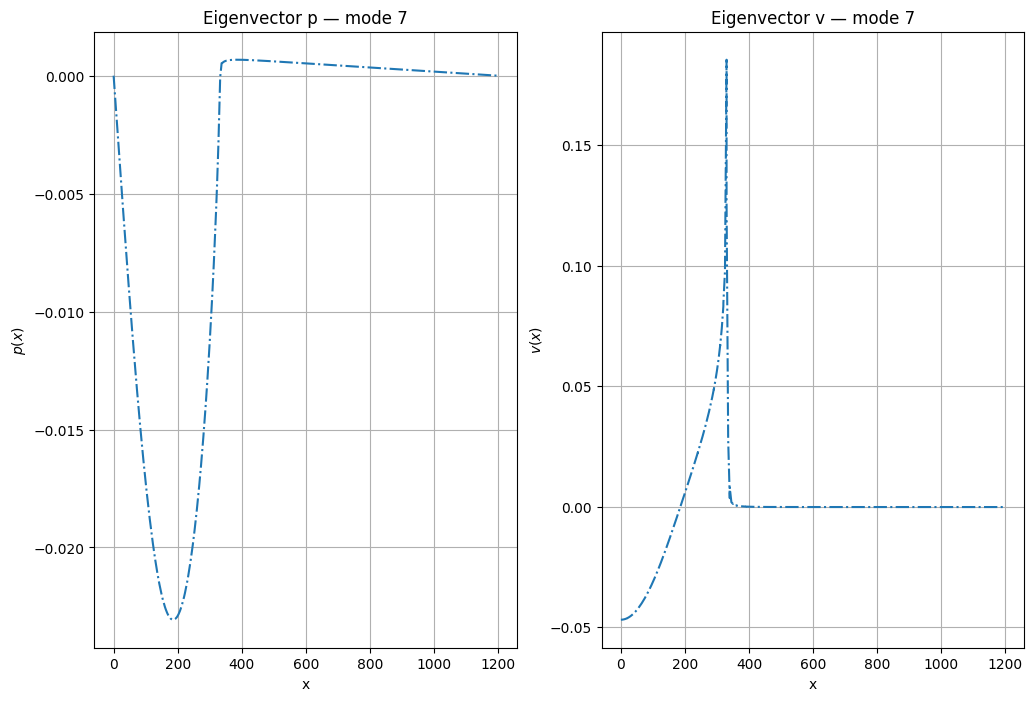

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 3 ---
ax = axes[0]

x_num_3, y_num_3 = get_function_plot_data(p[n])


ax.plot(x_num_3, np.real(y_num_3), label="singular", linestyle="-.")
ax.set_xlabel("x")
ax.set_ylabel("$p(x)$")
ax.set_title(f"Eigenvector p — mode {nn}")
ax.grid(True)
# ax.legend()

# --- v, modo 3 ---
ax = axes[1]

x_num_3, y_num_3 = get_function_plot_data(v[n])


ax.plot(x_num_3, np.real(y_num_3), label="singular", linestyle="-.")
ax.set_xlabel("x")
ax.set_ylabel("$v(x)$")
ax.set_title(f"Eigenvector v — mode {nn}")
ax.grid(True)
# ax.legend()

print("$\omega=$",eigs[n])

